In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2
import random
import numpy as np

In [2]:
(x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data()

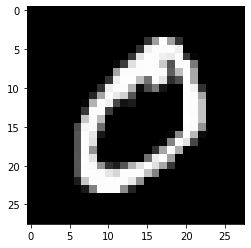

In [3]:
plt.imshow(x_train[1],cmap="gray")

In [4]:
x_train = x_train/255.0
x_test = x_test/255.0

In [5]:
x_train[0].shape

(28, 28)

In [6]:
def get_model(level):
    encoder_input = keras.Input(shape=(28, 28, 1), name='img')
    x = keras.layers.Flatten()(encoder_input)
    
    encoder_output = keras.layers.Dense(level*level, activation="relu")(x)

    encoder = keras.Model(encoder_input, encoder_output, name='encoder')

    decoder_input = keras.layers.Dense(level*level, activation="relu")(encoder_output)
    x = keras.layers.Dense(784, activation="relu")(decoder_input)
    decoder_output = keras.layers.Reshape((28, 28, 1))(x)

    opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

    autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
    autoencoder.summary()

    autoencoder.compile(opt, loss='mse')
    return (autoencoder,encoder)


In [7]:
autoencoder,encoder = get_model(8)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 784)               50960     
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 105,360
Trainable params: 105,360
Non-trainable params: 0
_________________________________________________

In [8]:
with tf.device('/GPU:0'):
    autoencoder.fit(x_train,x_train,epochs=3,batch_size=32,validation_split=0.1)

Epoch 1/3
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0227 - val_loss: 0.0167
Epoch 2/3
1688/1688 [==============================] - 2s 1ms/step - loss: 0.0157 - val_loss: 0.0152
Epoch 3/3
1688/1688 [==============================] - 2s 1ms/step - loss: 0.0148 - val_loss: 0.0145


In [9]:
example = autoencoder.predict([x_test[0].reshape(-1,28,28,1)])

In [10]:
example.shape

(1, 28, 28, 1)

(-0.5, 27.5, 27.5, -0.5)

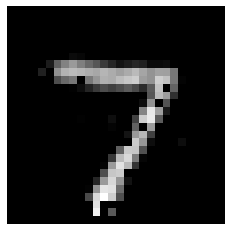

In [11]:
plt.imshow(example.reshape(28,28),cmap="gray")
plt.axis("off")

(-0.5, 27.5, 27.5, -0.5)

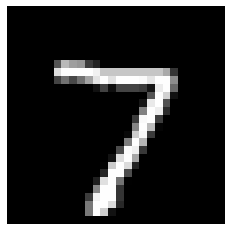

In [12]:
plt.imshow(x_test[0],cmap="gray")
plt.axis("off")

(-0.5, 7.5, 7.5, -0.5)

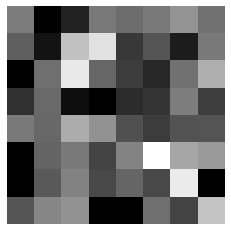

In [13]:
decoded_img = encoder.predict([x_test[0].reshape(-1,28,28,1)])[0]
plt.imshow(decoded_img.reshape((8,8)),cmap="gray")
plt.axis("off")

# Denoising

In [14]:
def add_noise(img,random_chance=5):
    noisy = []
    for row in img:
        new_row = []
        for pix in row:
            if(random.choice(range(100))<= random_chance):
                new_val = random.uniform(0,1)
                new_row.append(new_val)
            else:
                new_row.append(pix)
                
        noisy.append(new_row)
    return np.array(noisy)

In [15]:
noisy=[]
for i in range(10):
    noised = add_noise(x_test[i],10)
    noisy.append(noised)

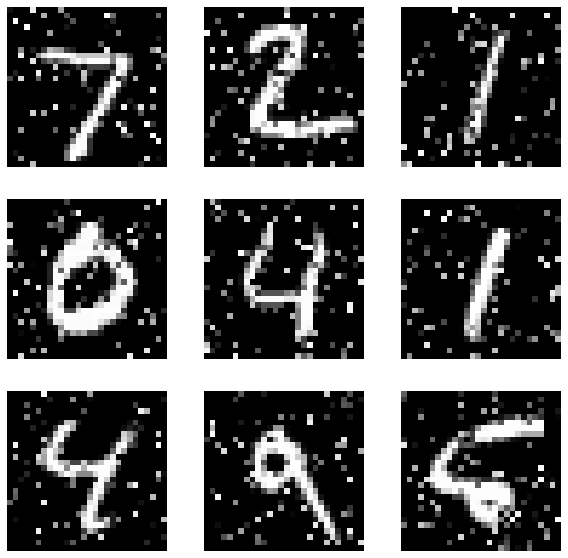

In [16]:
fig = plt.figure(figsize=(10,10))
columns=3
rows=3
t=0;
for i in range(1,columns*rows+1):
    fig.add_subplot(rows,columns,i)
    plt.imshow(noisy[t],cmap="gray")
    plt.axis("off")
    t+=1
plt.show()


In [17]:
denoised = []
for i in range(10):
    denoised.append(autoencoder.predict([noisy[i].reshape(-1,28,28,1)])[0])


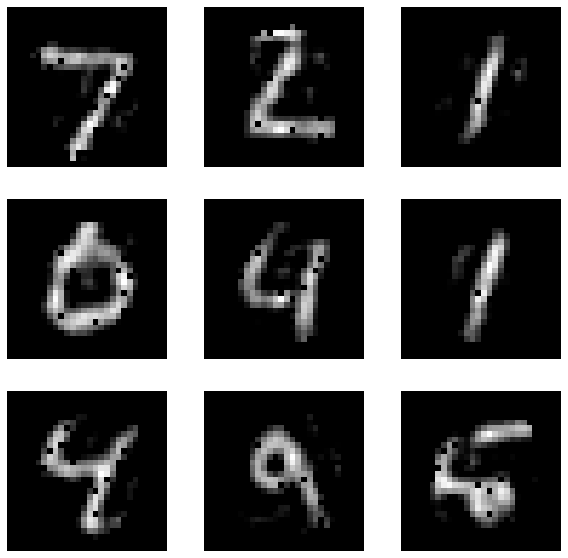

In [18]:
fig = plt.figure(figsize=(10,10))
columns=3
rows=3
t=0;
for i in range(1,columns*rows+1):
    fig.add_subplot(rows,columns,i)
    plt.imshow(denoised[t].reshape((28,28)),cmap="gray")
    plt.axis("off")
    t+=1
plt.show()